In [1]:
from util import get_langs

langs = get_langs()
langs

/home/tollef/git/STS-augmented-pair-encoder/pair_encoder/model.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


['amh', 'arq', 'ary', 'eng', 'esp', 'hau', 'kin', 'mar', 'tel']

In [2]:
import pandas as pd
from util import get_data
from sklearn.model_selection import StratifiedShuffleSplit

adversarial_train = {}
adversarial_dev = {}

for lang in langs:
    train = get_data(lang = lang, train=True, clean=False)
    if lang == "esp":
        dev = get_data(lang = lang, train=False, clean=False)
    else:
        # dev = get_data(lang = lang, train=False, clean=False)
        dev = get_data(lang = lang, test=True, clean=False)  # actually test
    # train = train.sample(n=len(dev), random_state=0)
    
    train = train[['s1', 's2']]
    dev = dev[['s1', 's2']]

    # assign label
    train['label'] = 0
    dev['label'] = 1

    # merge dataframes:
    df = pd.concat([train, dev])
    # stratified split:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    for train_index, test_index in sss.split(df[['s1', 's2']], df['label']):
        _train = df.iloc[train_index]
        _dev = df.iloc[test_index]

    adversarial_train[lang] = _train
    adversarial_dev[lang] = _dev


In [3]:
adversarial_train['eng'].value_counts('label')

label
0    4400
1    2080
Name: count, dtype: int64

eng


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

mar


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tel


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ary


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


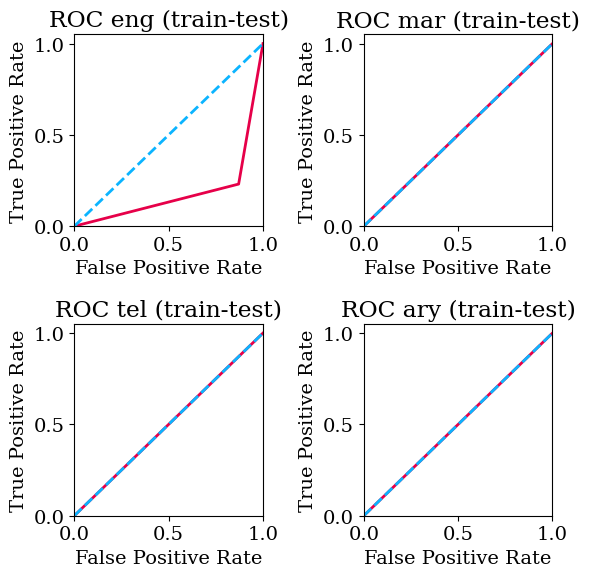

In [4]:
from sentence_transformers import CrossEncoder, InputExample
from sentence_transformers.cross_encoder.evaluation import CESoftmaxAccuracyEvaluator
from torch.utils.data import DataLoader
import logging

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from util import palette

plt.rc('font', family='serif')
plt.rc('font', size=14)

def plot_auc(fpr, tpr, roc_auc, lang, ax):
    lw = 2
    ax.plot(fpr, tpr, color=palette[0], lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color=palette[1], lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC {lang} (train-test)')
    # ax.legend(loc="lower right")

def make_data(lang):
    train = adversarial_train[lang]
    dev = adversarial_dev[lang]
    train_examples = []
    dev_examples = []
    for i, row in train.iterrows():
        train_examples.append(InputExample(texts=[row['s1'], row['s2']], label=row['label']))
    for i, row in dev.iterrows():
        dev_examples.append(InputExample(texts=[row['s1'], row['s2']], label=row['label']))

    return train_examples, dev_examples

# fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()  # Flatten the array of axes to easily iterate over it

# for lang in langs:
#     print(lang)
#     train_examples, dev_examples = make_data(lang)
langs = "ary amh eng tel".split()

langs = "eng mar tel ary".split()


for i, lang in enumerate(langs):
    if lang not in langs:
        continue
    print(lang)
    train_examples, dev_examples = make_data(lang)

    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)
    evaluation = CESoftmaxAccuracyEvaluator.from_input_examples(dev_examples, name='adversarial_dev')
    model = CrossEncoder("xlm-roberta-base", num_labels=2)
    epochs = 5
    model.fit(
        train_dataloader=train_dataloader,
        evaluator=evaluation,
        # optimizer_params={
        #     "lr": 1e-5,
        # },
        epochs=epochs,
        warmup_steps=len(train_dataloader) * 0.1 * epochs,
        show_progress_bar=False
    )
    model_predictions = model.predict([example.texts for example in dev_examples])
    model_predictions = [1 if pred[0] > pred[1] else 0 for pred in model_predictions]
    fpr, tpr, _ = roc_curve([example.label for example in dev_examples], model_predictions)
    roc_auc = auc(fpr, tpr)
    plot_auc(fpr, tpr, roc_auc, lang=lang, ax=axs[i])
    # plot_auc(fpr, tpr, roc_auc, lang=lang)
    
# increase spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)


plt.tight_layout()
plt.savefig("FIGURES/roc_auc_traintest.pdf")
plt.show()